<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week4/EVA4_P2_S4_Face_Recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading standard Libraries and project modules


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Load modules/models from EVA course
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!rm -rf Modules
!rm -rf models
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!mv /content/Phase2/S4_FaceRecognition/models /content/
!rm -rf Phase2

#print("Loaded EVA4 Modules")
from Modules import *

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 32kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


# 2. Load Data & Set Data Loaders

In [ ]:
# Downloading dataset and unziping into proper folder structure
!rm -rf Data_*.zip
!rm -rf Data_Processed
!rm -rf data

!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S4/Data_v2_Processed.zip
!unzip -q Data_v2_Processed.zip

## 2.1 Load images in to DataSet and also perform data transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadFaceDataset('/content/Data_Processed', batch_size = 128)

['AishwaryaRai', 'Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'ElonMusk', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'MahendraSinghDhoni', 'Mahmoud_Abbas', 'MalalaYousafzai', 'Megawati_Sukarnoputri', 'Michael_Bloomberg', 'Naomi_Watts', 'NarendraModi', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras', 'PriyankaChopra', 'RahulGandhi'

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

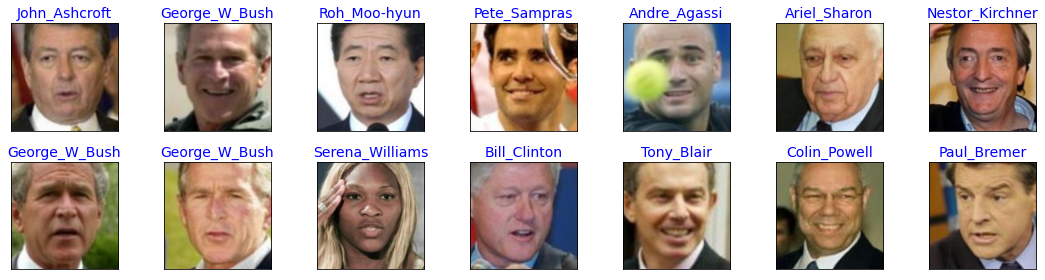

In [ ]:
data.show_batch(save_as="sample.jpg")

# 4. Defining the pre-trained inception network and customize its layer

In [ ]:
import torch.optim as optim
from models.inception_resnet_v1 import InceptionResnetV1
#from torch_lr_finder import LRFinder

print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(data.class_names))
#print(model_ft)

#Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

Running on device: cuda:0


[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
# Put all beginning layers in an nn.Sequential . 
# model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

# Setting gradient off for parameters of remaining base layers 
for param in model_ft.parameters():
  param.requires_grad = False

In [ ]:
from models.inception_adder import *

# Adding last layers for our purpose
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(data.class_names))
#model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)

# 5. Training Mobilenet Model - Only last layers

## 5.1 Find hyper parameter lr value using LR Finder


Learning rate search finished. See the graph with {finder_name}.plot()


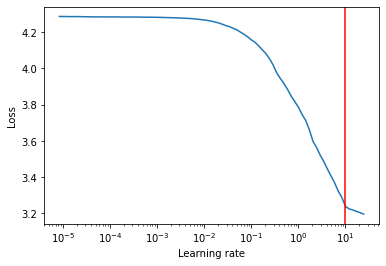

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=50, num_iter=100)
lr_finder.plot(show_lr=10.0) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=10.0, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=10.0, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=10)

In [ ]:
#from Modules import *
model_res, FT_losses, plotData = train_face_recog_model(model_ft, data, device, criterion, optimizer_ft, 
                                                        scheduler,num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.1748 Acc: 0.5348
val Loss: 0.5278 Acc: 0.9446
Epoch 1/9
----------
train Loss: 0.2430 Acc: 0.9843
val Loss: 0.0962 Acc: 0.9919
Epoch 2/9
----------
train Loss: 0.0612 Acc: 0.9964
val Loss: 0.0632 Acc: 0.9940
Epoch 3/9
----------
train Loss: 0.0348 Acc: 0.9978
val Loss: 0.0584 Acc: 0.9930
Epoch 4/9
----------
train Loss: 0.0267 Acc: 0.9987
val Loss: 0.0564 Acc: 0.9930
Epoch 5/9
----------
train Loss: 0.0201 Acc: 0.9987
val Loss: 0.0550 Acc: 0.9930
Epoch 6/9
----------
train Loss: 0.0168 Acc: 0.9987
val Loss: 0.0533 Acc: 0.9930
Epoch 7/9
----------
train Loss: 0.0146 Acc: 0.9987
val Loss: 0.0523 Acc: 0.9940
Epoch 8/9
----------
train Loss: 0.0124 Acc: 0.9987
val Loss: 0.0519 Acc: 0.9930
Epoch 9/9
----------
train Loss: 0.0127 Acc: 0.9987
val Loss: 0.0516 Acc: 0.9940
Training complete in 1m 48s
Best val Acc: 0.993958


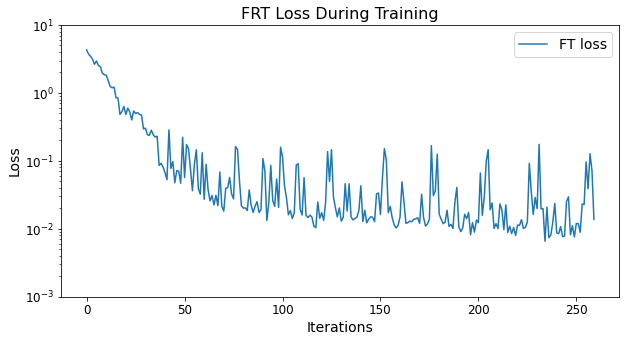

In [ ]:
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training",fontsize=16)
plt.plot(FT_losses, label="FT loss")
plt.xlabel("Iterations",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0.001,10)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

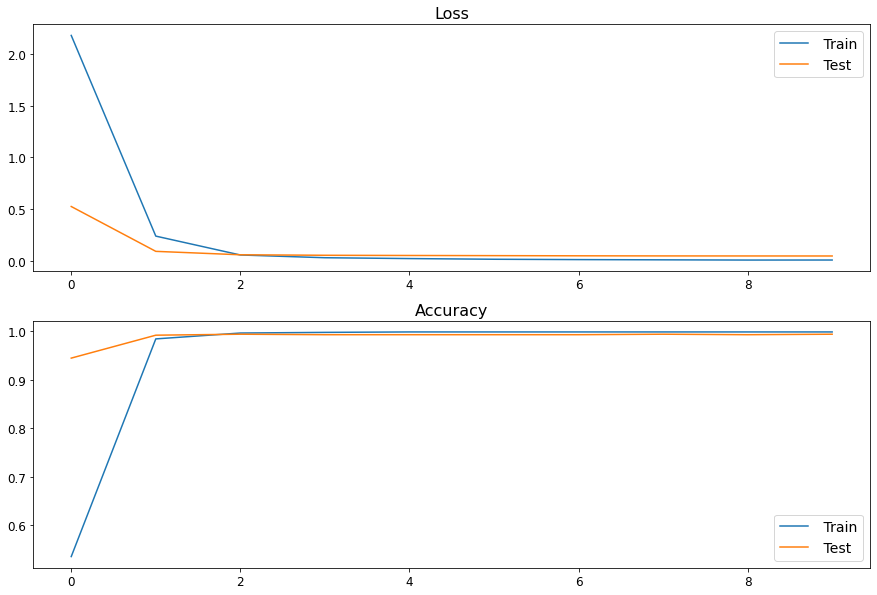

In [ ]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

---------------------------------- Predictions  ---------------------------------


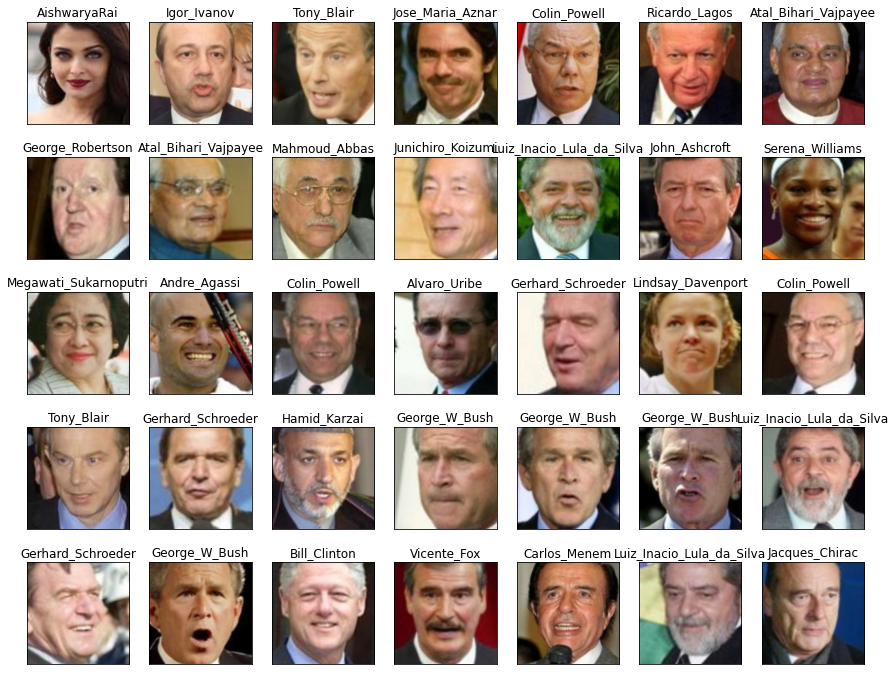

In [ ]:
device = torch.device('cuda:0')
print("---------------------------------- Predictions  ---------------------------------")
visualize_face_recog_model(model_res, data, device,"visualize_2.jpg")

# 6. Custom dataset results - 10 Celebrities/Policitians

------------  Prediction on Validation set of Images for Aishwarya Rai -------------------


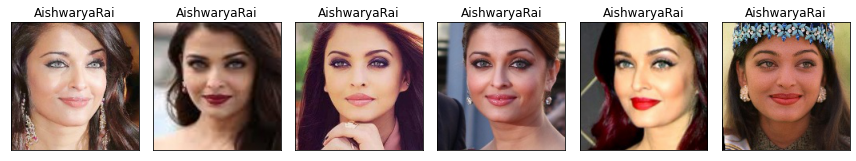

------------  Prediction on Validation set of Images for Elon Musk -------------------


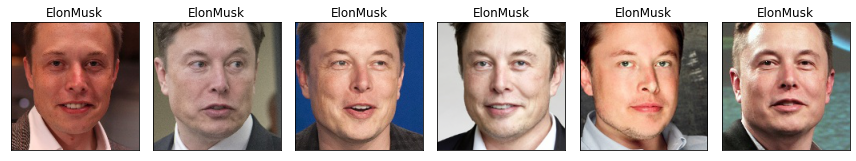

------------  Prediction on Validation set of Images for Mahendra Singh Dhoni -------------------


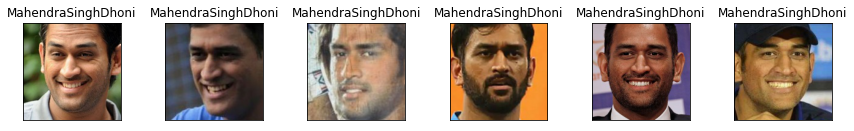

------------  Prediction on Validation set of Images for Malala Yousafzai -------------------


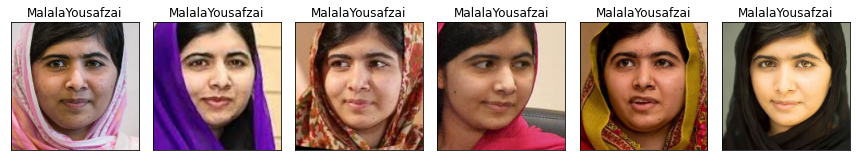

------------  Prediction on Validation set of Images for Narendra Modi -------------------


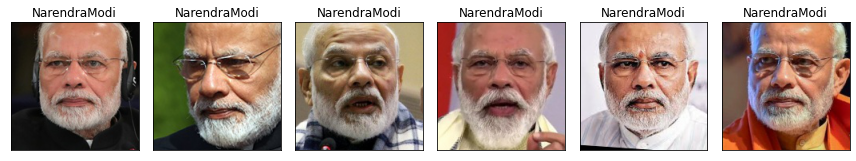

------------  Prediction on Validation set of Images for Priyanka Chopra -------------------


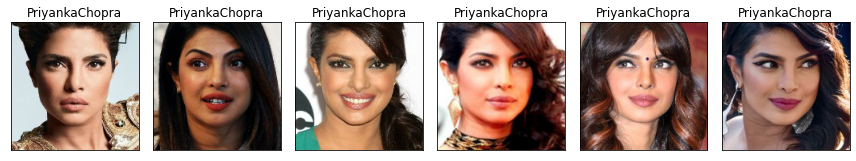

------------  Prediction on Validation set of Images for Rahul Gandhi -------------------


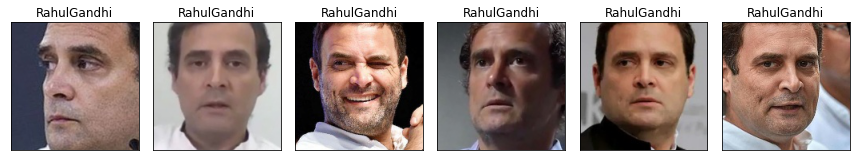

------------  Prediction on Validation set of Images for Sachin Tendulkar -------------------


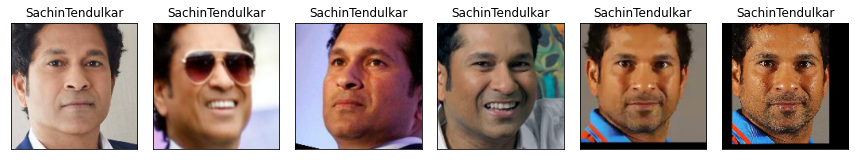

------------  Prediction on Validation set of Images for Shahrukh Khan -------------------


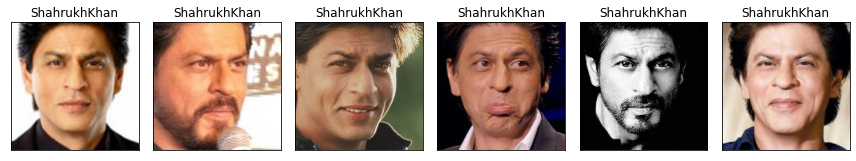

------------  Prediction on Validation set of Images for Shreya Ghoshal -------------------


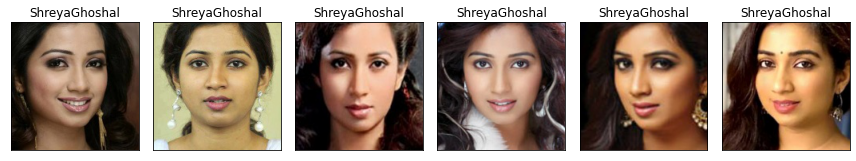

In [ ]:
ShowCustomDataFaces(model_res, data, device,dataType='val', num_images=6)

# 7. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_res.state_dict(), '/content/inception_resnet_face_recog_gpu_v2.pt')

In [ ]:
# Load CPU Model
device = torch.device('cpu')
model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(data.class_names))

# Put all beginning layers in an nn.Sequential . 
# model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.
model = nn.Sequential(*list(model.children())[:-5])

# Adding last layers for our purpose
model.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model.logits = nn.Linear(layer_list[4].in_features, len(data.class_names))


model.load_state_dict(torch.load('/content/inception_resnet_face_recog_gpu_v2.pt',
                                 map_location=device))

<All keys matched successfully>

In [ ]:
# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 160, 160))
traced_model.save('inception_resnet_face_recog_v2.pt')